# Credit Card Fraud Detection

## Import the required packages & load the dataset

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import matplotlib as plt
import sys
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

sys.path.append("/home/ec2-user/.local/lib/python3.6/site-packages")
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
#        print(os.path.join(dirname, filename))
        input_path=os.path.join(dirname, filename)
        print(input_path)
# Any results you write to the current directory are saved as output.

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

./input/creditcardcsvpresent.csv


In [2]:
data=pd.read_csv(input_path)
data.head()

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,NaN,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,NaN,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,NaN,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,NaN,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y


# Modify the data type

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
datanew = reduce_mem_usage(data)

Memory usage of dataframe is 0.28 MB --> 0.18 MB (Decreased by 37.5%)


# Data Pre-processing

## Drop the empty column

In [5]:
datanew.drop(['Transaction date'], axis = 1, inplace = True)

In [6]:
datanew.describe()

,Merchant_id,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq
count,3.075000e+03,3075.000000,3075.000000,3075.000000,3075.000000,3075.0,3075.000000
mean,5.026634e+09,inf,9876.400391,0.957398,55.737561,inf,0.391870
std,9.870778e+08,inf,10135.341797,2.192391,206.634779,inf,1.548479
min,3.160041e+09,4.011719,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.170814e+09,269.750000,2408.781128,0.000000,0.000000,0.0,0.000000
50%,5.025578e+09,502.500000,6698.892090,0.000000,0.000000,0.0,0.000000
75%,5.889625e+09,765.250000,14422.568848,0.000000,0.000000,0.0,0.000000
max,6.665906e+09,2000.000000,108000.000000,20.000000,998.000000,998.0,9.000000


In [7]:
df= datanew.corr()
df.head()

,Merchant_id,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq
Merchant_id,1.000000,0.018225,0.046065,-0.016165,0.088802,0.091623,0.118599
Average Amount/transaction/day,0.018225,1.000000,0.587110,-0.009684,0.060424,0.060279,0.071849
Transaction_amount,0.046065,0.587110,1.000000,0.259309,0.252298,0.259662,0.297623
Total Number of declines/day,-0.016165,-0.009684,0.259309,1.000000,0.094834,0.081138,0.085028
Daily_chargeback_avg_amt,0.088802,0.060424,0.252298,0.094834,1.000000,0.953664,0.884611


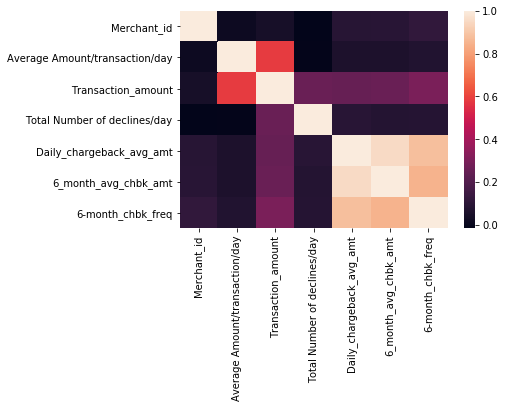

In [8]:
heat_map = sb.heatmap(df)

## Drop the empty rows

In [9]:
#Drop Rows that contain missing values
dataf=datanew.dropna()

In [10]:
dataf.head()

,Merchant_id,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,500.0,26000.0,N,0,Y,Y,800,677.0,6,Y


## Standardizing the numeric features

In [11]:
s_scaler = preprocessing.StandardScaler()
dataf.iloc[:,1:3] = s_scaler.fit_transform(dataf.iloc[:,1:3])
dataf.iloc[:,4:5] = s_scaler.fit_transform(dataf.iloc[:,4:5])
dataf.iloc[:,7:10] = s_scaler.fit_transform(dataf.iloc[:,7:10])


In [12]:
dataf.head()

,Merchant_id,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,-1.422010,-0.678569,N,1.844224,Y,Y,-0.269783,-0.256647,-0.253109,Y
1,3160040998,-1.422010,-0.550284,N,1.844224,Y,Y,-0.269783,-0.256647,-0.253109,Y
2,3160041896,-1.129061,-0.498674,Y,1.844224,N,N,-0.269783,-0.256647,-0.253109,Y
3,3160141996,-1.129061,-0.480368,Y,3.212815,N,N,-0.269783,-0.256647,-0.253109,Y
4,3160241992,-0.051489,1.591090,N,-0.436762,Y,Y,3.602411,4.084684,3.622292,Y


## Applying One-hot encoding to categorical features

In [13]:
#Converts categorical variable into dummy/indicator variables.
dataf=pd.get_dummies(dataf)


In [14]:
dataf.head()

,Merchant_id,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,Is declined_N,Is declined_Y,isForeignTransaction_N,isForeignTransaction_Y,isHighRiskCountry_N,isHighRiskCountry_Y,isFradulent_N,isFradulent_Y
0,3160040998,-1.422010,-0.678569,1.844224,-0.269783,-0.256647,-0.253109,1,0,0,1,0,1,0,1
1,3160040998,-1.422010,-0.550284,1.844224,-0.269783,-0.256647,-0.253109,1,0,0,1,0,1,0,1
2,3160041896,-1.129061,-0.498674,1.844224,-0.269783,-0.256647,-0.253109,0,1,1,0,1,0,0,1
3,3160141996,-1.129061,-0.480368,3.212815,-0.269783,-0.256647,-0.253109,0,1,1,0,1,0,0,1
4,3160241992,-0.051489,1.591090,-0.436762,3.602411,4.084684,3.622292,1,0,0,1,0,1,0,1


In [15]:
dataf.columns


Index(['Merchant_id', 'Average Amount/transaction/day', 'Transaction_amount',
       'Total Number of declines/day', 'Daily_chargeback_avg_amt',
       '6_month_avg_chbk_amt', '6-month_chbk_freq', 'Is declined_N',
       'Is declined_Y', 'isForeignTransaction_N', 'isForeignTransaction_Y',
       'isHighRiskCountry_N', 'isHighRiskCountry_Y', 'isFradulent_N',
       'isFradulent_Y'],
      dtype='object')

In [16]:
dataf.shape

(3075, 15)

In [17]:
X= dataf.iloc[:,:13]
Y=dataf[['isFradulent_Y']]

In [18]:
print("X.shape",X.shape)
print("Y.shape",Y.shape)

X.shape (3075, 13)
Y.shape (3075, 1)


In [19]:
X[:10]


,Merchant_id,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,Is declined_N,Is declined_Y,isForeignTransaction_N,isForeignTransaction_Y,isHighRiskCountry_N,isHighRiskCountry_Y
0,3160040998,-1.422010,-0.678569,1.844224,-0.269783,-0.256647,-0.253109,1,0,0,1,0,1
1,3160040998,-1.422010,-0.550284,1.844224,-0.269783,-0.256647,-0.253109,1,0,0,1,0,1
2,3160041896,-1.129061,-0.498674,1.844224,-0.269783,-0.256647,-0.253109,0,1,1,0,1,0
3,3160141996,-1.129061,-0.480368,3.212815,-0.269783,-0.256647,-0.253109,0,1,1,0,1,0
4,3160241992,-0.051489,1.591090,-0.436762,3.602411,4.084684,3.622292,1,0,0,1,0,1
5,3160241992,-0.051489,1.689771,-0.436762,3.602411,4.084684,3.622292,1,0,0,1,0,1
6,3160272997,-0.865236,0.139249,-0.436762,4.086436,1.958907,4.268192,1,0,1,0,1,0
7,3162041996,-1.129061,0.123706,8.687182,-0.269783,-0.256647,-0.253109,0,1,1,0,1,0
8,3162041996,-1.129061,-0.370536,8.687182,-0.269783,-0.256647,-0.253109,0,1,1,0,1,0
9,3162041996,-1.129061,-0.279010,8.687182,-0.269783,-0.256647,-0.253109,0,1,1,0,1,0


## Splitting the dataset into Training & Testing set

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y,random_state = 101, test_size=0.3)

In [21]:
print("X_train.shape",X_train.shape)
print("X_test.shape",X_test.shape)
print("y_train.shape",y_train.shape)
print("y_test.shape",y_test.shape)

X_train.shape (2152, 13)
X_test.shape (923, 13)
y_train.shape (2152, 1)
y_test.shape (923, 1)


## Training a Logistic Regression Model

In [22]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
predicted1= model.predict(X_test)
# print(model.score(X_test, y_test))
print(f"Accuracy: {model.score(X_test, y_test)*100}%")

Accuracy: 84.29035752979415%


In [23]:
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion_Matrix\n",confusion_matrix(y_test, predicted1))
print(classification_report(y_test, predicted1))

Confusion_Matrix
 [[778   0]
 [145   0]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       778
           1       0.00      0.00      0.00       145

    accuracy                           0.84       923
   macro avg       0.42      0.50      0.46       923
weighted avg       0.71      0.84      0.77       923



## Training a XGBoost Classifier

In [24]:
!pip3 install xgboost --user

You are using pip version 19.0.2, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [25]:
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier(n_estimators=20, learning_rate=0.05, max_depth=1)
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]
# evaluate predictions
# accuracy = model.score(X_test, y_test)
# print(accuracy)
print(f"Accuracy: {model.score(X_test, y_test)*100}%")

Accuracy: 91.11592632719393%
